# Collecting and Preprocessing Financial Data

Seho Jeong, Sogang University

In this note I focus on downloading and visualizing financial data from various sources. Here I use Python for implementation.

**References**
- **Scheuch, Christoph, Stefan Voigt, Patrick Weiss, and Christoph Frey. 2020.** "Tidy Finance with Python." Chapman & Hall/CRC.

We first import Python packages used in this note. I use `pykrx` and `yfinance` to download financial data.

In [57]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from plotnine import *
from mizani.formatters import percent_format

from pykrx import stock
import yfinance as yf

## Working with Stock Returns

Stock returns are one of the most common data used in asset pricing literature. Also it is really easy that beginners can also learn it fast.

### Downloading Data

We first download daily stock prices for one stock symbol, e.g., the Apple stock (AAPL), directly from the data provider Yahoo Finance.

In [18]:
price = yf.download(tickers='AAPL', 
                    start='2000-01-01',
                    end='2024-12-31',
                    auto_adjust=False)
price.reset_index(inplace=True)
price.columns = ['date', 'adj_close', 'close', 'high', 'low', 'open', 'volume']

[*********************100%***********************]  1 of 1 completed


In [39]:
price.head()

,date,adj_close,close,high,low,open,volume
0,2000-01-03,0.840094,0.999442,1.004464,0.907924,0.936384,535796800
1,2000-01-04,0.769266,0.915179,0.987723,0.903460,0.966518,512377600
2,2000-01-05,0.780523,0.928571,0.987165,0.919643,0.926339,778321600
3,2000-01-06,0.712978,0.848214,0.955357,0.848214,0.947545,767972800
4,2000-01-07,0.746750,0.888393,0.901786,0.852679,0.861607,460734400


The code above returns a dataframe with seven columns: `date`, `adj_close`, `close`, `high`, `low`, `open`, and `volume`. The adjusted prices are corrected for anything that might affect the stock price after the market closes, e.g., stock splits and dividends. These actions affect the quoted price, but they have no direct impact on the investors who hold the stock. Therefore, we often rely on adjusted prices when it comes to analyzing the returns an investor would have earned by holding the stock continuously.

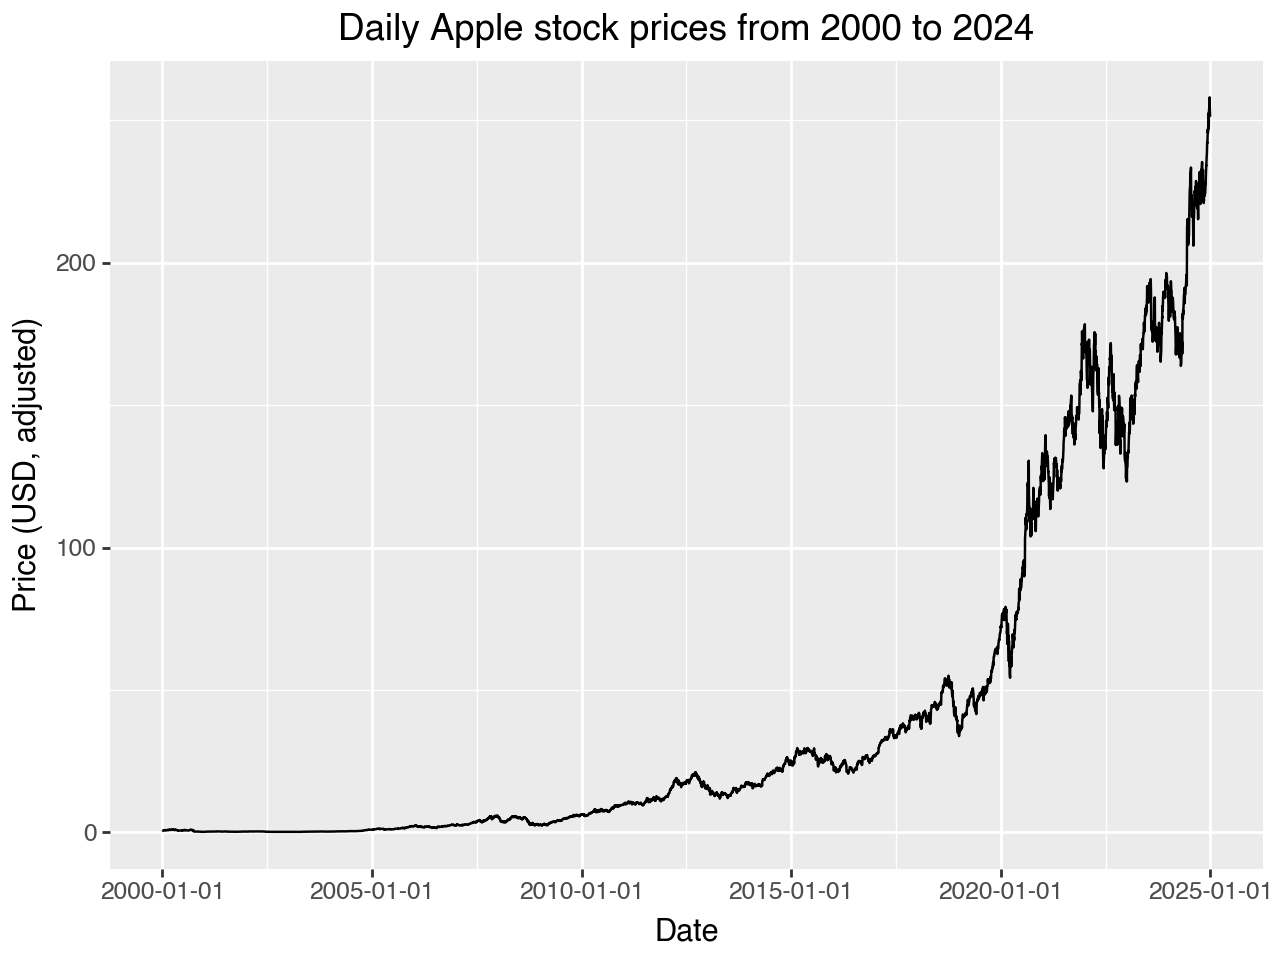

In [65]:
apple_prices_figure = (
    ggplot(price, aes(y='adj_close', x='date'))
    + geom_line()
    + labs(x='Date', y='Price (USD, adjusted)', title='Daily Apple stock prices from 2000 to 2024')
)

apple_prices_figure.show()

### Computing Returns

Instead of analyzing prices, I compute daily returns defined as $$R_t = \frac{P_t}{P_{t-1}} - 1$$ where $P_t$ is the adjusted price at the end of day $t$. 

In [49]:
returns = (price
    .sort_values('date')
    .assign(ret=lambda x: x['adj_close'].pct_change())
    .get(['date', 'ret'])
)
returns = returns.dropna()

In [50]:
returns.head()

,date,ret
1,2000-01-04,-0.084310
2,2000-01-05,0.014633
3,2000-01-06,-0.086538
4,2000-01-07,0.047369
5,2000-01-10,-0.017588


The resulting dataframe has two columns and the first column contains the daily returns. 

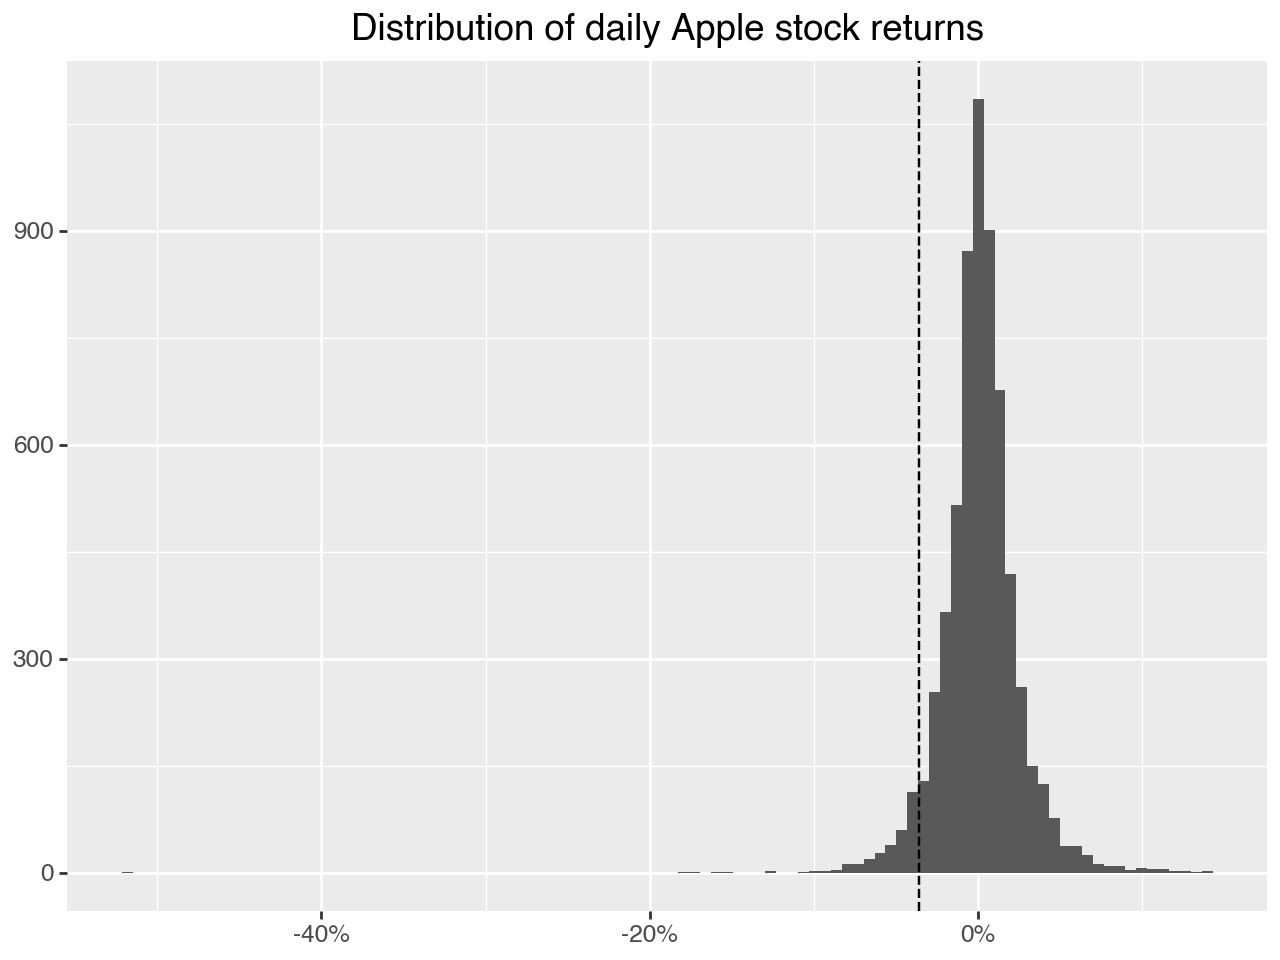

In [59]:
apple_returns_figure = (
    ggplot(returns, aes(x='ret'))
    + geom_histogram(bins=100)
    + geom_vline(aes(xintercept=returns['ret'].quantile(0.05)), linetype='dashed')
    + labs(x='', y='', title='Distribution of daily Apple stock returns')
    + scale_x_continuous(labels=percent_format())
)
apple_returns_figure.show()

Before proceeding with any data, a typical task is to compute and analyze the summary statistics for the main variables of interest.

In [64]:
pd.DataFrame(returns['ret'].describe()).round(3).T

,count,mean,std,min,25%,50%,75%,max
ret,6287.0,0.001,0.024,-0.519,-0.01,0.001,0.013,0.139


We see that the maximum daily return was 13.9 percent during the 2000-2024 period. Perhaps not surprisingly, the average daily return is close to but slightly above 0. In line with the illustration above, the large losses on the day with the minimum returns indicate a strong asymmetry in the distribution of returns.

You can also compute these summary statistics for each year individually. More specifically, the few lines of code below compute the summary statistics from above for individual groups of data defined by the values of the column year. The summary statistics, therefore, allow an eyeball analysis of the time-series dynamics of the daily return distribution.

In [66]:
(returns['ret']
.groupby(returns['date'].dt.year)
.describe()
.round(3))

,count,mean,std,min,25%,50%,75%,max
date,,,,,,,,
2000,251.0,-0.003,0.055,-0.519,-0.034,-0.002,0.027,0.137
2001,248.0,0.002,0.039,-0.172,-0.023,-0.001,0.027,0.129
2002,252.0,-0.001,0.031,-0.150,-0.019,-0.003,0.018,0.085
2003,252.0,0.002,0.023,-0.081,-0.012,0.002,0.015,0.113
2004,252.0,0.005,0.025,-0.056,-0.009,0.003,0.016,0.132
2005,252.0,0.003,0.024,-0.092,-0.010,0.003,0.017,0.091
2006,251.0,0.001,0.024,-0.063,-0.014,-0.002,0.014,0.118
2007,251.0,0.004,0.024,-0.070,-0.009,0.003,0.018,0.105
2008,253.0,-0.003,0.037,-0.179,-0.024,-0.001,0.019,0.139


### Scaling Up the Analysis

In [67]:
dow_jones = yf.download("^DJI", start="2023-01-01", end="2025-08-13")

/var/folders/n5/bkphn15s0kzc1lsr8x64v8y00000gn/T/ipykernel_1686/2901959763.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
[*********************100%***********************]  1 of 1 completed


In [68]:
dow_jones

Price,Close,High,Low,Open,Volume
Ticker,^DJI,^DJI,^DJI,^DJI,^DJI
Date,,,,,
2023-01-03,33136.371094,33387.519531,32850.570312,33148.898438,355930000
2023-01-04,33269.769531,33409.101562,33033.480469,33165.140625,379400000
2023-01-05,32930.078125,33191.718750,32812.328125,33191.718750,337920000
2023-01-06,33630.609375,33710.660156,32997.390625,33055.300781,360740000
2023-01-09,33517.648438,33935.109375,33487.660156,33664.390625,327840000
...,...,...,...,...,...
2025-08-06,44193.121094,44290.089844,44017.710938,44196.609375,518970000
2025-08-07,43968.640625,44498.429688,43799.199219,44430.089844,492480000
